# Tasks

Dataset collection – Download the main Steam Reviews dataset (and optionally the other ones if needed).

Tag collection – Gather the complete set of Steam tags (either from a list or by extracting tags attached to games in your dataset).

Data cleaning & preprocessing – Remove duplicates, filter uninformative reviews (“very good game”), normalize text (tokenization, lowercasing, stopword removal, etc.).

Dataset integration – Ensure reviews and tags are linked to the same games; build a consistent structure combining review text and game tags.

Exploratory data analysis – Inspect distribution of reviews per game, most frequent tags, review length, balance between positive/negative reviews, etc.

Baseline method implementation – Train Word2Vec embeddings per game and compute cosine similarity between reviews and tag embeddings.

Advanced modeling – Experiment with alternative methods (e.g., supervised learning, other embedding models, feature importance analysis).

Evaluation design – Decide on the scoring system (exact match vs. order-sensitive comparison of tags with Steam’s official tag list).

Evaluation & analysis – Run the models, compare outputs against Steam’s tags, and analyze results (per game and overall).

Reporting & discussion – Interpret findings in terms of your research questions (correlation of reviews and tags, best features for tag extraction).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.backends
import matplotlib.pyplot as plt
import tqdm

1. Getting Data

In [2]:
df = pd.read_csv("./archive/dataset.csv")
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [3]:
gameNames = df["app_name"].unique()
gameCodes = df["app_id"].unique()

print(gameNames.shape)
print(gameCodes.shape)
print(gameCodes)

(9364,)
(9972,)
[    10   1002 100400 ...   9990  99900  99910]


In [5]:
print(df["review_text"].shape[0])
df.loc[df["review_text"].str.split().str.len() > 3, "review_text"].shape[0]

6417106


5126570

In [6]:
df["word_count"] = df["review_text"].str.split().str.len()

bins   = [-1, 0, 1, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100, float("inf")]

def generate_bin_labels(bins):
    labels = []
    for i in range(len(bins)-1):
        lower = int(bins[i]) + 1 if i != 0 else int(bins[i])
        upper = (bins[i+1])
        
        # Last bin: handle infinity
        if upper == float("inf"):
            labels.append(f"{lower}+")
        else:
            labels.append(f"{lower}–{int(upper)}")
    return labels
labels = generate_bin_labels(bins)

counts = pd.cut(df["word_count"], bins=bins, labels=labels, right=True).value_counts().sort_index()

print(counts)


word_count
-1–0          186
1–1         60694
2–3       1222351
4–5        296477
6–10       719003
11–15      568744
16–20      432384
21–30      608413
31–40      420614
41–50      311944
51–75      520914
76–100     316970
101+       931107
Name: count, dtype: int64


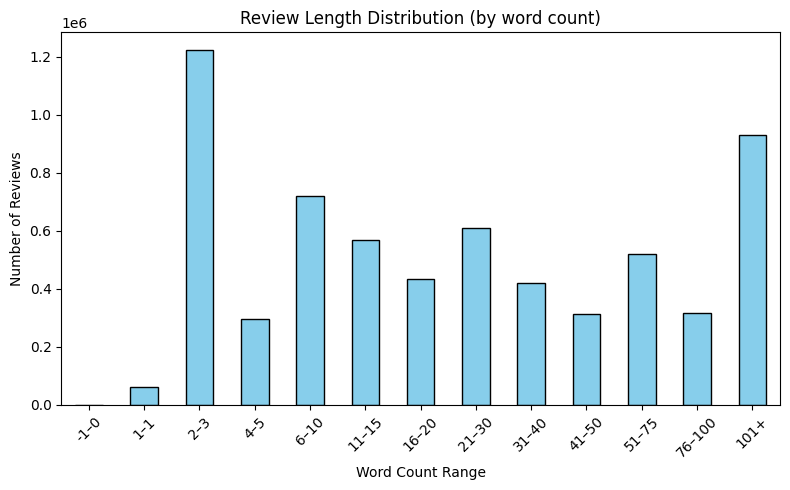

In [7]:
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(8,5))
counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Review Length Distribution (by word count)")
plt.xlabel("Word Count Range")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
import requests

def get_tags(APPID:int):
    url = f"https://steamspy.com/api.php?request=appdetails&appid={APPID}"

    response = requests.get(url)

    if response.status_code == 200:
        return response.json()['tags']
    else:
        print(f"API fail for {APPID}")
        


In [9]:
def fetch_and_save_tags(gameCodes, batch_size=500, output_file='output.csv', get_tags_func=None):
    """
    Fetch tags for games and append to CSV.

    Args:
        gameCodes (list): List of APPIDs to fetch tags for.
        batch_size (int): Number of games to process in this batch.
        output_file (str): CSV file to append results.
        get_tags_func (callable): Function to fetch tags. Must accept APPID and return tag dict or list.

    Returns:
        nonetags (list): List of APPIDs where tags could not be fetched.
    """
    # Load existing tags if CSV exists
    try:
        gameTags = pd.read_csv(output_file)
    except FileNotFoundError:
        gameTags = pd.DataFrame(columns=["APPID", "tags"])
    
    # Filter gameCodes to only new games not already in CSV
    existing_ids = set(gameTags['APPID'].astype(int).tolist())
    gameCodes = [gid for gid in gameCodes if gid not in existing_ids]

    if not gameCodes:
        print("No new games to process.")
        return [], gameTags
    
    # Track games that failed
    nonetags = []

    # Process games in batch
    for i, APPID in tqdm.tqdm(enumerate(gameCodes), total=len(gameCodes), desc="Fetching tags"):
        if i >= batch_size:
            break
        # Skip APPIDs already in CSV
        if APPID in gameTags['APPID'].values:
            print(f"Skipping {APPID}, already in CSV.")
            continue
        try:
            tags = get_tags_func(APPID)
        except Exception as e:
            print(f"Error fetching tags for {APPID}: {e}")
            nonetags.append(APPID)
            continue
        if tags is not None and tags != []:
            gameTags.loc[len(gameTags)] = [APPID, tags]
        else:
            nonetags.append(APPID)

    # Save updated CSV
    gameTags.to_csv(output_file, index=False)

    print(f"Processed {min(batch_size, len(gameCodes))} games. {len(nonetags)} failed.")
    return nonetags, gameTags

print(gameCodes.shape)
nonetags, gameTags = fetch_and_save_tags(gameCodes, batch_size=500, output_file='output.csv', get_tags_func=get_tags)

(9972,)


Fetching tags: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]

Processed 10 games. 10 failed.


In [10]:
APPID=108700
tagss = dict(gameTags['tags'])
tags = {}
for d in tagss.values():
    for k, v in d.items():
        tags[k] = 0

for k,v in list(gameTags.loc[gameTags['APPID'] == APPID, 'tags'])[0].items():
    tags[k] = v

print(tags)


AttributeError: 'str' object has no attribute 'items'

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

print("--- getting model ---")
model = SentenceTransformer('all-MiniLM-L6-v2')

print("--- 2. getting tags ---")
# tags = get_tags(10)

print("--- 3. embedding tags ---")
tag_embeddings = model.encode([str(i) for i in list(tags.keys())], convert_to_tensor=True)



--- getting model ---
--- 2. getting tags ---
--- 3. embedding tags ---


In [ ]:
print("--- 4. embedding reviews ---")

print(len(df.loc[df['app_id'] == APPID, 'app_name'].to_list()))
print(df.loc[df['app_id'] == APPID, 'app_name'].to_list()[0])

filtered_reviews = df.loc[df['app_id'] == APPID, 'review_text'] # all reviews for CS (APPID==10)
review = random_review = filtered_reviews.sample(n=1).iloc[0]

scores=[]

for review in tqdm.tqdm(filtered_reviews.to_list(), "reviewing"):
    review_embedding = model.encode(str(review), convert_to_tensor=True)
    cosine_scores = util.cos_sim(review_embedding, tag_embeddings)
    scores.append(cosine_scores)

cosine_scores = average_scores = np.mean(np.array(scores), axis=0)

--- 4. embedding reviews ---
232
Death Rally


reviewing: 100%|██████████| 232/232 [00:04<00:00, 52.36it/s]


In [ ]:
print(tags)

{'Action': 71, 'FPS': 0, 'Multiplayer': 11, 'Shooter': 6, 'Classic': 0, 'Team-Based': 0, 'First-Person': 0, 'Competitive': 0, 'Tactical': 0, "1990's": 0, 'e-sports': 0, 'PvP': 0, 'Old School': 0, 'Military': 0, 'Strategy': 0, 'Survival': 0, 'Score Attack': 0, '1980s': 0, 'Assassin': 0, 'Nostalgia': 0, '2D Fighter': 0, 'Martial Arts': 0, 'Intentionally Awkward Controls': 0, 'Physics': 0, 'Indie': 0, 'Fighting': 0, 'Singleplayer': 8, '2D': 0, 'Animation & Modeling': 0, 'Software': 0, 'Zombies': 0, 'World War II': 0, 'Co-op': 0, 'Moddable': 0, 'War': 0, 'Online Co-Op': 0, 'Gore': 0, 'Historical': 0, 'Great Soundtrack': 0, 'Horror': 0, 'Tanks': 0, 'Adventure': 0, 'Utilities': 0, 'Design & Illustration': 0, 'Photo Editing': 0, 'Education': 0, 'Game Development': 0, 'Point & Click': 0, 'Fantasy': 0, 'Retro': 0, 'Pixel Graphics': 0, 'Puzzle': 0, 'Female Protagonist': 0, 'Escape Room': 0, 'Comedy': 0, 'Space': 0, 'Futuristic': 0, 'Robots': 0, 'Epic': 0, 'Replay Value': 0, 'Funny': 0, 'Remake':

In [ ]:
print("--- 5. getting scores --- \n\n")
# cosine_scores = util.cos_sim(review_embedding, tag_embeddings)

for tag, score in sorted(zip(list(tags.keys()), cosine_scores[0]), key=lambda x: x[1], reverse=True):
    print(tag, float(score))

for tag, score in sorted(zip(list(tags.keys()), list(tags.values())), key=lambda x: x[1], reverse=True):
    print(tag, float(score))




--- 5. getting scores --- 


Combat Racing 0.29950255155563354
Games Workshop 0.291063517332077
Action RPG 0.2883937358856201
Wargame 0.2794741690158844
Arcade 0.2790223956108093
RPG 0.27632033824920654
Card Game 0.2654644846916199
Game Development 0.2611851096153259
MMORPG 0.2593928575515747
Massively Multiplayer 0.257588654756546
Board Game 0.25538820028305054
Action-Adventure 0.24958838522434235
Card Battler 0.24456185102462769
Remake 0.23978012800216675
Nostalgia 0.2365574836730957
Party-Based RPG 0.23509888350963593
Multiplayer 0.23143255710601807
Racing 0.23058541119098663
Twin Stick Shooter 0.22874006628990173
CRPG 0.2279132753610611
Adventure 0.2248903214931488
On-Rails Shooter 0.2205996811389923
Survival Horror 0.21715374290943146
Arena Shooter 0.21417120099067688
Sequel 0.21357262134552002
Open World Survival Craft 0.21023277938365936
Great Soundtrack 0.2092438042163849
JRPG 0.20688854157924652
Grand Strategy 0.20063920319080353
2D Fighter 0.19957901537418365
Action Roguelike

In [ ]:
sorted_list = sorted(zip(list(tags.keys()), 
                          cosine_scores[0], 
                          list(tags.keys()), 
                          list(tags.values())), key=lambda x: x[1], reverse=True)

# Build DataFrame
df_compare = pd.DataFrame({
    'Tag': [t for t, _, _, _ in sorted_list],
    'Tag Score': [s for _, s, _, _ in sorted_list],
    'Ground Tag': [t for _, _, t, _ in sorted_list],
    'Ground Score': [s for _, _, _, s in sorted_list]
})

print(df_compare.head(25))


                      Tag  Tag Score             Ground Tag  Ground Score
0           Combat Racing   0.299503          Combat Racing            24
1          Games Workshop   0.291064         Games Workshop             0
2              Action RPG   0.288394             Action RPG             0
3                 Wargame   0.279474                Wargame             0
4                  Arcade   0.279022                 Arcade            25
5                     RPG   0.276320                    RPG             0
6               Card Game   0.265464              Card Game             0
7        Game Development   0.261185       Game Development             0
8                  MMORPG   0.259393                 MMORPG             0
9   Massively Multiplayer   0.257589  Massively Multiplayer             0
10             Board Game   0.255388             Board Game             0
11       Action-Adventure   0.249588       Action-Adventure             0
12           Card Battler   0.244562  

In [ ]:
import pandas as pd

# Example inputs
# tags = list of tags for first list
# cosine_scores[0] = corresponding cosine scores
# tags_dict = dictionary for the second list, e.g., tags_dict = get_tags(10)

# Sort both sets
sorted_list1 = sorted(zip(list(tags.keys()), cosine_scores[0]), key=lambda x: x[1], reverse=True)
sorted_list2 = sorted(zip(list(tags.keys()), list(tags.values())), key=lambda x: x[1], reverse=True)

# Make sure both lists have the same length for DataFrame (pad with None if needed)
max_len = max(len(sorted_list1), len(sorted_list2))
sorted_list1 += [(None, None)] * (max_len - len(sorted_list1))
sorted_list2 += [(None, None)] * (max_len - len(sorted_list2))

# Build DataFrame
df_compare = pd.DataFrame({
    'Tag': [t for t, s in sorted_list1],
    'Tag_Score': [s for t, s in sorted_list1],
    'Ground_Tag': [t for t, s in sorted_list2],
    'Ground_Score': [s for t, s in sorted_list2]
})

# Sort by Score_List1 descending
df_compare = df_compare.sort_values(by='Tag_Score', ascending=False).reset_index(drop=True)

print(df_compare.head(25))


                      Tag  Tag_Score        Ground_Tag  Ground_Score
0           Combat Racing   0.299503            Racing            98
1          Games Workshop   0.291064            Action            71
2              Action RPG   0.288394            Remake            34
3                 Wargame   0.279474            Arcade            25
4                  Arcade   0.279022     Combat Racing            24
5                     RPG   0.276320          Top-Down            21
6               Card Game   0.265464  Vehicular Combat            12
7        Game Development   0.261185       Multiplayer            11
8                  MMORPG   0.259393      Singleplayer             8
9   Massively Multiplayer   0.257589         Isometric             8
10             Board Game   0.255388           Shooter             6
11       Action-Adventure   0.249588               FPS             0
12           Card Battler   0.244562           Classic             0
13                 Remake   0.2397